In [1]:
from uav_routing.environment.data import load
callibrated_path ="/Users/kirtisoglu/Documents/GitHub/UAV-Routing/uav_routing/notebooks/calibrated_env.pkl"
data = load(callibrated_path)

graph, drone = data['graph'], data['drone']

from uav_routing.environment.plot import plot_graph_with_positions
#plot_graph_with_positions(graph.nodes, graph.edges)

In [ ]:
def check_for_orphaned_nodes(nodes, all_imp_arcs, impossible_nodes):
    ins_count, out_counts = 0, 0
    active_nodes = [n for n in nodes if n not in impossible_nodes]
    for n in active_nodes:
        # Check if anyone can go TO n
        ins = [i for i in nodes if (i, n) not in all_imp_arcs]
        # Check if n can go TO anyone
        outs = [j for j in nodes if (n, j) not in all_imp_arcs]
        
        if not ins and n != 0:
            print(f"WARNING: Node {n} is unreachable! (No feasible incoming arcs)")
        if not outs and n != 0:
            print(f"WARNING: Node {n} is a dead end! (No feasible outgoing arcs)")

        ins_count += len(ins)
        out_counts += len(outs)
    
        if ins_count != out_counts:
         

    print("total ins:", ins_count, "total outs:", out_counts)

all_imp_arcs = set(time_window_infeasible_arcs + three_point_infeasible_arcs)
check_for_orphaned_nodes(list(graph.nodes), all_imp_arcs, impossible_nodes)

In [ ]:
from uav_routing.solver.prune import prune_and_report
nodes, feasible_arcs = prune_and_report(graph, drone)
print(len(nodes))
print(len(feasible_arcs))

In [ ]:
import itertools as it
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def draw_labeled_multigraph(G, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}={attrs[attr_name]}"
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )


nodes = "ABC"
prod = list(it.product(nodes, repeat=2))
pair_dict = {f"Product x {i}": prod * i for i in range(1, 5)}


fig, axes = plt.subplots(2, 2)
for (name, pairs), ax in zip(pair_dict.items(), np.ravel(axes)):
    G = nx.MultiDiGraph()
    for i, (u, v) in enumerate(pairs):
        G.add_edge(u, v, w=round(i / 3, 2))
    draw_labeled_multigraph(G, "w", ax)
    ax.set_title(name)
fig.tight_layout()
plt.show()

In [2]:
from uav_routing.solver.exact import solve_exact_benchmark_subgraph

max_attempt = 5 

for attempt in range(max_attempt):
    r, sol= solve_exact_benchmark_subgraph(graph, drone, prune=False, time_limit=1000)
    mdl = sol.model
    mdl.export_as_lp(path=f"my_model_{attempt}.lp")
    # 1. Check if a solution was actually found
    if sol:
        print(f"Objective Value: {sol.objective_value}")
    else:
        print("No feasible solution found.")

    # 2. Check the specific termination reason
    details = mdl.solve_details
    print(f"Status: {details.status}")
    print(f"Time: {details.time}s")
    print(f"Gap: {details.mip_relative_gap}")

    # Logic to identify the limit hit
    if "time limit" in details.status.lower():
        print("STOPPED: Time Limit Reached")
    elif "node limit" in details.status.lower():
        print("STOPPED: Node Limit Reached")
    elif "memory limit" in details.status.lower():
        print("STOPPED: Tree Memory Limit Reached")
    elif "optimal" in details.status.lower():
        print("SUCCESS: Found Optimal Solution")
    print(f"Model Objective Sense: {mdl.objective_sense}")

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Emphasis_Numerical                      1
CPXPARAM_TimeLimit                               1000
CPXPARAM_MIP_Tolerances_AbsMIPGap                0.050000000000000003
Tried aggregator 2 times.
MIQCP Presolve eliminated 3467 rows and 2166 columns.
MIQCP Presolve modified 10050 coefficients.
Aggregator did 7650 substitutions.
Reduced MIQCP has 27339 rows, 28536 columns, and 84944 nonzeros.
Reduced MIQCP has 2167 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQCP has 7650 quadratic constraints.
Presolve time = 0.10 sec. (126.76 ticks)
Probing fixed 1312 vars, tightened 12684 bounds.
Probing time = 0.05 sec. (54.00 ticks)
Cover probing fixed 0 vars, tightened 2312 bounds.
Clique table members: 369.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 11 threads.
Root relaxation solution time = 0

In [ ]:
from uav_routing.solver.exact import solve_exact_benchmark_subgraph

max_attempt = 5 

for attempt in range(max_attempt):
    r, sol= solve_exact_benchmark_subgraph(graph, drone, prune=False)
    mdl = sol.model
    mdl.export_as_lp(path=f"my_model_{attempt}.lp")
    # 1. Check if a solution was actually found
    if sol:
        print(f"Objective Value: {sol.objective_value}")
    else:
        print("No feasible solution found.")

    # 2. Check the specific termination reason
    details = mdl.solve_details
    print(f"Status: {details.status}")
    print(f"Time: {details.time}s")
    print(f"Gap: {details.mip_relative_gap}")

    # Logic to identify the limit hit
    if "time limit" in details.status.lower():
        print("STOPPED: Time Limit Reached")
    elif "node limit" in details.status.lower():
        print("STOPPED: Node Limit Reached")
    elif "memory limit" in details.status.lower():
        print("STOPPED: Tree Memory Limit Reached")
    elif "optimal" in details.status.lower():
        print("SUCCESS: Found Optimal Solution")
    mdl.clear() # Removes all constraints and variables



Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_Scale                              1
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 11
CPXPARAM_Emphasis_Numerical                      1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              1
CPXPARAM_MIP_Strategy_MIQCPStrat                 2
CPXPARAM_DetTimeLimit                            2000000
CPXPARAM_MIP_Tolerances_AbsMIPGap                0.050000000000000003
CPXPARAM_MIP_Tolerances_Integrality              9.9999999999999995e-07
CPXPARAM_Barrier_ConvergeTol                     9.9999999999999995e-07
Tried aggregator 2 times.
MIQCP Presolve eliminated 3467 rows and 2166 columns.
MIQCP Presolve modified 10050 coefficients.
Aggregator did 7650 substitutions.
Reduced MIQCP has 27339 rows, 28536 columns, and 84944 nonzeros.
Reduced MIQCP has 2167 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQCP has 7650

iki ayri speed, ayni kenar uzerinde optimal olamaz. Contradiction bul. Toplam sureye bak, 

2. slope lari sifir al (objective function ve speed independent olacak), time window sifir sonsuz (loiter). information sifirdan buyuk. Dolayisiyla speed sadece energy ye bagli oalcak. Her yerde 44 le gitmeli.
# Disable the Pre-processor

In [2]:
from uav_routing.solver.exact import solve_exact_benchmark_subgraph

r, sol= solve_exact_benchmark_subgraph(graph, drone, prune=False, time_limit=1000)


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 11
CPXPARAM_Emphasis_Numerical                      1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              1
CPXPARAM_MIP_Strategy_HeuristicFreq              -1
CPXPARAM_DetTimeLimit                            2000000
CPXPARAM_MIP_Tolerances_AbsMIPGap                0.050000000000000003
Tried aggregator 2 times.
MIQCP Presolve eliminated 3467 rows and 2166 columns.
MIQCP Presolve modified 10050 coefficients.
Aggregator did 7650 substitutions.
Reduced MIQCP has 27339 rows, 28536 columns, and 84944 nonzeros.
Reduced MIQCP has 2167 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQCP has 7650 quadratic constraints.
Presolve time = 0.11 sec. (126.76 ticks)
Probing fixed 1312 vars, tightened 12654 bounds.
Probing time = 0.06 sec. (55.05 ticks)
Cover probing fixed 0 vars, tightened 227

In [ ]:
from uav_routing.solver.exact import solve_exact_benchmark_subgraph

r, sol= solve_exact_benchmark_subgraph(graph, drone, prune=False, time_limit=1000)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 11
CPXPARAM_Emphasis_Numerical                      1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              1
CPXPARAM_MIP_Strategy_HeuristicFreq              -1
CPXPARAM_DetTimeLimit                            2000000
CPXPARAM_MIP_Tolerances_AbsMIPGap                0.050000000000000003
Tried aggregator 2 times.
MIQCP Presolve eliminated 3467 rows and 2166 columns.
MIQCP Presolve modified 10050 coefficients.
Aggregator did 7650 substitutions.
Reduced MIQCP has 27339 rows, 28536 columns, and 84944 nonzeros.
Reduced MIQCP has 2167 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQCP has 7650 quadratic constraints.
Presolve time = 0.11 sec. (126.76 ticks)
Probing fixed 1312 vars, tightened 12654 bounds.
Probing time = 0.06 sec. (55.05 ticks)
Cover probing fixed 0 vars, tightened 227

In [2]:
nodes = [0, 20, 24, 25]
edges = [(0, 20), (20, 24), (24, 25), (25, 0)]
v = 44.31


# Parameters
N = list(graph.nodes)
base = drone.base
T_max = drone.max_time 
speed_max = drone.speed_max
speed_min = drone.speed_min
max_energy = drone.max_energy


w = {node: 1 for node in nodes}
x = {edge: 1 for edge in edges}

L = {edge: graph.edges[edge]['distance'] for edge in edges}
t = {edge: L[edge]/v for edge in edges}

a = {0: 0, 
     20: t[(0, 20)], 
     24: t[(0, 20)] + t[(20, 24)], 
     25: t[(0, 20)] + t[(20, 24)] + t[(24, 25)],
     'final': t[(0, 20)] + t[(20, 24)] + t[(24, 25)] + t[(25, 0)]}


y = {edge: L[edge]**3 / t[edge]**2 for edge in edges}
z = {edge: t[edge]**2 / L[edge] for edge in edges}
s = {edge: L[edge]**2 / t[edge] for edge in edges}


print("t", t)
print("a", a)
print("L", L)
print("y", y)
print("z", z)
print("s", s)


t {(0, 20): 225.68269013766644, (20, 24): 112.84134506883322, (24, 25): 45.136538027533284, (25, 0): 341.51988152610147}
a {0: 0, 20: 225.68269013766644, 24: 338.52403520649966, 25: 383.66057323403294, 'final': 725.1804547601344}
L {(0, 20): 10000.0, (20, 24): 5000.0, (24, 25): 2000.0, (25, 0): 15132.745950421557}
y {(0, 20): 19633761.0, (20, 24): 9816880.5, (24, 25): 3926752.2000000007, (25, 0): 29711271.72642947}
z {(0, 20): 5.0932676627773965, (20, 24): 2.5466338313886983, (24, 25): 1.018653532555479, (25, 0): 7.7075125598307705}
s {(0, 20): 443100.0, (20, 24): 221550.0, (24, 25): 88620.00000000001, (25, 0): 670531.9730631792}


In [7]:
print("---- SOC Constraints ----")    
print("--------")
print("-------- t^2 <= z * L")
for edge in edges:
    print(f"{t[edge]**2} <= {z[edge]*L[edge]}")  # 1. t^2 <= z * L

print("--------")
print("-------- L^2 <= t * s")
for edge in edges:
    print(f"{L[edge]**2} <= {t[edge]*s[edge]}")  # 2. L^2 <= t * s
print("--------")
print("-------- s^2 <= L * y")
for edge in edges:
    print(f"{s[edge]**2} <= {L[edge]*y[edge]}")  # 3. s^2 <= L * y
print("--------")
print("-------- y <= v_max * t")
for edge in edges:
    print(f"{y[edge]} <= {(speed_max**3)*t[edge]}")  # 4. y <= v_max * t
print("--------")
print("-------- z <= v_min * t")
for edge in edges:
    print(f"{z[edge]} <= {t[edge]/speed_min}")  # 5. z <= v_min * t


---- SOC Constraints ----
--------
-------- t^2 <= z * L
50932.676627773966 <= 50932.676627773966
12733.169156943492 <= 12733.169156943492
2037.3070651109583 <= 2037.307065110958
116635.82947760238 <= 116635.82947760238
--------
-------- L^2 <= t * s
100000000.0 <= 100000000.0
25000000.0 <= 25000000.0
4000000.0 <= 4000000.0000000005
229000000.00000003 <= 229000000.00000003
--------
-------- s^2 <= L * y
196337610000.0 <= 196337610000.0
49084402500.0 <= 49084402500.0
7853504400.000003 <= 7853504400.000001
449613126900.00006 <= 449613126900.00006
--------
-------- y <= v_max * t
19633761.0 <= 51225682.69013767
9816880.5 <= 25612841.345068835
3926752.2000000007 <= 10245136.538027532
29711271.72642947 <= 77518524.22867604
--------
-------- z <= v_min * t
5.0932676627773965 <= 11.284134506883323
2.5466338313886983 <= 5.642067253441661
1.018653532555479 <= 2.256826901376664
7.7075125598307705 <= 17.075994076305072


In [8]:
print("---- Time Windows ----")    
print("--------")
print("-------- a[i] >= e_i * w[i] and a[i] <= l_i * w[i]")
for node in nodes:
    e_i, l_i = graph.nodes[node]['time_window']
    print(f"{e_i * w[node]} <= {a[node]} <= {l_i * w[node]}")  # a[i] <= l_i * w[i]



---- Time Windows ----
--------
-------- a[i] >= e_i * w[i] and a[i] <= l_i * w[i]
0.0 <= 0 <= 3058.6068577820984
24.74601017623057 <= 225.68269013766644 <= 180.64587428648318
160.8490661454987 <= 338.52403520649966 <= 356.34254653772024
418.20757197829664 <= 383.66057323403294 <= 554.3106279475647


In [ ]:
for i in N:
    for j in N:
        if i!=j:
            dist = graph[i][j]['distance']
            
            # Path and Speed Bounds
            mdl.addConstr(L[i, j] >= dist * x[i, j], name=f'dist_min_{i}_{j}')
            mdl.addConstr(L[i, j] <= speed_max * t[i, j], name=f'speed_max_bound_{i}_{j}')
            mdl.addConstr(L[i, j] >= speed_min * t[i, j], name=f'speed_min_bound_{i}_{j}')
            mdl.addConstr(t[i, j] <= T_max * x[i, j], name=f'time_bound_{i}_{j}')

In [ ]:

            

# --- MTZ Subtour Elimination ---
# Part 1: Transitions between non-base nodes
for i in N:
    for j in N:
        if i != j and i != base:
            # a_j >= a_i + t_ij - T_max(1 - x_ij)
            mdl.addConstr(a[j] >= a[i] + t[i, j] - T_max * (1 - x[i, j]), name=f'mtz_lb_{i}_{j}')
            
            # a_j <= a_i + t_ij + T_max(1 - x_ij)
            mdl.addConstr(a[j] <= a[i] + t[i, j] + T_max * (1 - x[i, j]), name=f'mtz_ub_{i}_{j}')

# Part 2: Transitions starting from the base
for j in N:
    if j != base:
        # a_j >= t_base_j - T_max(1 - x_base_j)
        mdl.addConstr(a[j] >= t[base, j] - T_max * (1 - x[base, j]), name=f'base_mtz_lb_{j}')
        
        # a_j <= t_base_j + T_max(1 - x_base_j)
        mdl.addConstr(a[j] <= t[base, j] + T_max * (1 - x[base, j]), name=f'base_mtz_ub_{j}')
        
        
# Information = info_at_lowest * w_i + info_slope * (arrival_time - start_of_window * w_i)
obj = sum(graph.nodes[i]['info_at_lowest'] * w[i] + graph.nodes[i]['info_slope'] * (a[i] - graph.nodes[i]['time_window'][0] * w[i]) for i in nodes)
# 7. Energy Budget
# Assuming drone.socp_energy_function returns a linear combination of t, y, z
total_energy = gp.quicksum(drone.socp_energy_function(t[i, j], y[i, j], z[i, j]) for (i, j) in keys)
mdl.addConstr(total_energy <= max_energy, name='energy_budget')


# Update model to integrate variables/constraints
mdl.update()
# Update model to integrate variables/constraints


# Print model statistics for verification
print("="*70)
print("MODEL STATISTICS")
print("="*70)
print(f"Number of variables: {mdl.NumVars}")
print(f"  - Binary variables: {sum(1 for v in mdl.getVars() if v.VType == GRB.BINARY)}")
print(f"  - Continuous variables: {sum(1 for v in mdl.getVars() if v.VType == GRB.CONTINUOUS)}")
print(f"Number of linear constraints: {mdl.NumConstrs}")
print(f"Number of quadratic constraints: {mdl.NumQConstrs}")
print(f"Number of nodes: {len(N)}")
print(f"Number of edges: {len(keys)}")
print("\nDrone parameters:")
print(f"  speed_max = {speed_max}")
print(f"  speed_min = {speed_min}")
print(f"  T_max = {T_max}")
print(f"  max_energy = {max_energy}")
print("\nCalculated bounds:")
#print(f"  max_L = {max_L:.2e}")
#print(f"  max_y = {max_y:.2e}")
#print(f"  max_z = {max_z:.2e}")
#print(f"  max_s = {max_s:.2e}")
print("="*70)




In [4]:
mdl = sol.model
if sol:
    cpx = mdl.get_cplex()
    
    # Access the kappa constant through the 'quality_metric' mapping
    try:
        # CPLEX constant for kappa is often indexed by 'kappa' or '13'
        kappa = cpx.solution.quality_metric.kappa
        print(f"Condition Number (Kappa): {kappa}")
    except AttributeError:
        # Fallback for some CPLEX versions
        kappa = cpx.solution.get_float_quality(cpx.solution.quality_metric.kappa)
        print(f"Condition Number (Kappa): {kappa}")
else:
    print("Model did not solve, cannot calculate Kappa.")

Condition Number (Kappa): 39


In [5]:
from uav_routing.environment.data import load
callibrated_path ="/Users/kirtisoglu/Documents/GitHub/UAV-Routing/uav_routing/notebooks/calibrated_env.pkl"
data = load(callibrated_path)

graph, drone = data['graph'], data['drone']

for edge in graph.edges:
    dist = graph.edges[edge]['distance']
    graph.edges[edge]['distance'] = dist /10
    
for node in graph.nodes:
    if node != drone.base:
        graph.nodes[node]['time_window'] = [0, 10000]


#nodes = [0, 20, 24, 25]
#subg = graph.subgraph(nodes)

from uav_routing.environment.plot import plot_graph_with_positions
#plot_graph_with_positions(graph.nodes, graph.edges)
from uav_routing.solver.exact import solve_gurobi_benchmark
results, mdl = solve_gurobi_benchmark(graph, drone, time_limit=600)

Set parameter Threads to value 0
Set parameter Seed to value 1
Set parameter Method to value 2
Set parameter NumericFocus to value 3
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
Set parameter FeasibilityTol to value 1e-09
MODEL STATISTICS
Number of variables: 15402
  - Binary variables: 2601
  - Continuous variables: 12801
Number of linear constraints: 20606
Number of quadratic constraints: 7650
Number of nodes: 51
Number of edges: 2550

Drone parameters:
  speed_max = 61
  speed_min = 20
  T_max = 3058.6068577820984
  max_energy = 48178306.634632744

Calculated bounds:
Set parameter TimeLimit to value 600
Set parameter MIPFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Non-default parameters:
TimeLimit  600
FeasibilityTol  1e-09
Method  2
MIPFocus  1
DualReductions  0
InfUnbdInfo  1
NumericFocus  3

In [4]:
import networkx as nx
import json
from networkx.readwrite import json_graph

data = json_graph.node_link_data(subg)
with open('subgraph.json', 'w') as f:
    json.dump(data, f)

/Users/kirtisoglu/cplex310env/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [5]:
drone

Drone(base=0, name='Bayraktar TB2', speed_min=20, speed_max=61, optimum_speed=44.31, c_0=0, c_1=0.0905, c_2=349095, time_factor=1, energy_factor=1, tour_time=3058.6068577820984)

In [ ]:
print("IsMIP:", mdl.IsMIP)
print("IsQCP:", mdl.IsQCP)
print("NumQConstrs:", mdl.NumQConstrs)

#IsQCP = 1 → model has quadratic constraints
#IsMIP = 0 → all variables are continuous

IsMIP: 1
IsQCP: 1
NumQConstrs: 2550


In [5]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

# Create a new model
m = gp.Model("SOCP_Feasibility_Test")

# Set up parameters
E_max = 10000.0  # Upper bound for y + z

# Decision variables
y = m.addVar(name="y", lb=1e-6)  # y > 0
z = m.addVar(name="z", lb=1e-6)  # z > 0
L = m.addVar(name="L", lb=1e-6)  # L > 0
t = m.addVar(name="t", lb=1e-6)  # t > 0
s = m.addVar(name="s", lb=1e-6)  # s > 0

# Add constraints
# Constraint 1: s^2 <= y*L (rotated second-order cone)
# In Gurobi, this is: s^2 <= 2*y*L (after division by 2 for standard form)
# Actually, s^2 <= y*L can be modeled as: ||[s]||_2 <= sqrt(y*L)
# Which in Gurobi's rotated cone form is: s^2 <= 2*y*L is equivalent to the rotated cone
# For rotated cone: u^2 + v^2 <= 2*w*z, we use addConstr with GRB.SOCP
# s^2 <= y*L means we need: s^2 <= y*L
# Gurobi's rotated cone is: x^2 + y^2 <= 2*u*v
# So s^2 <= y*L can be written as: s^2 <= 2*(y/2)*(L), but let's use direct form

# Constraint 1: s^2 <= y*L
# In Gurobi's rotated second-order cone: we can express as ||[s]||^2 <= y*L
# Using the quadratic form:
m.addConstr(s*s <= y*L, "cone_1_s_squared_le_yL")

# Constraint 2: L^2 <= s*t (rotated second-order cone)
m.addConstr(L*L <= s*t, "cone_2_L_squared_le_st")

# Constraint 3: t^2 <= z*L (rotated second-order cone)
m.addConstr(t*t <= z*L, "cone_3_t_squared_le_zL")

# Constraint 4: y + z <= E_max (linear constraint)
m.addConstr(y + z <= E_max, "linear_4_y_plus_z_le_Emax")

m.addConstr(L >= 1000, "distance")

# Set objective: minimize y + z (or could maximize, just testing feasibility)
m.setObjective(y + z, GRB.MAXIMIZE)

# Optimize
m.optimize()

# Print results
print("=" * 60)
print("SOCP FEASIBILITY TEST WITH GUROBI")
print("=" * 60)

if m.status == GRB.OPTIMAL:
    print("\n✓ FEASIBLE SOLUTION FOUND!")
    print(f"\nStatus: {m.status} (OPTIMAL)")
    print(f"\nObjective Value (y + z): {m.objVal:.6f}")
    print("\nVariable Values:")
    print(f"  y = {y.X:.6f}")
    print(f"  z = {z.X:.6f}")
    print(f"  L = {L.X:.6f}")
    print(f"  t = {t.X:.6f}")
    print(f"  s = {s.X:.6f}")
    
    print("\nConstraint Verification:")
    c1_lhs = s.X**2
    c1_rhs = y.X * L.X
    print(f"  Constraint 1 (s² ≤ y·L): {c1_lhs:.6f} ≤ {c1_rhs:.6f} ... {'✓' if c1_lhs <= c1_rhs + 1e-6 else '✗'}")
    
    c2_lhs = L.X**2
    c2_rhs = s.X * t.X
    print(f"  Constraint 2 (L² ≤ s·t): {c2_lhs:.6f} ≤ {c2_rhs:.6f} ... {'✓' if c2_lhs <= c2_rhs + 1e-6 else '✗'}")
    
    c3_lhs = t.X**2
    c3_rhs = z.X * L.X
    print(f"  Constraint 3 (t² ≤ z·L): {c3_lhs:.6f} ≤ {c3_rhs:.6f} ... {'✓' if c3_lhs <= c3_rhs + 1e-6 else '✗'}")
    
    c4_sum = y.X + z.X
    print(f"  Constraint 4 (y + z ≤ E_max): {c4_sum:.6f} ≤ {E_max:.6f} ... {'✓' if c4_sum <= E_max + 1e-6 else '✗'}")
    
    print("\nRelationship Verification:")
    ratio1 = L.X**3 / (t.X**2) if t.X != 0 else float('inf')
    ratio2 = t.X**2 / L.X if L.X != 0 else float('inf')
    print(f"  L³/t² = {ratio1:.6f} (should be ≤ y = {y.X:.6f}) ... {'✓' if ratio1 <= y.X + 1e-6 else '✗'}")
    print(f"  t²/L = {ratio2:.6f} (should be ≤ z = {z.X:.6f}) ... {'✓' if ratio2 <= z.X + 1e-6 else '✗'}")
    print(f"  L³/t² + t²/L = {ratio1 + ratio2:.6f} (should be ≤ y + z = {c4_sum:.6f}) ... {'✓' if ratio1 + ratio2 <= c4_sum + 1e-6 else '✗'}")

elif m.status == GRB.INFEASIBLE:
    print("\n✗ INFEASIBLE - No feasible solution exists!")
    print(f"Status: {m.status} (INFEASIBLE)")
    
elif m.status == GRB.UNBOUNDED:
    print("\n✗ UNBOUNDED - Problem is unbounded!")
    print(f"Status: {m.status} (UNBOUNDED)")
    
else:
    print(f"\nStatus: {m.status}")
    print("Optimization did not find an optimal solution.")

print("\n" + "=" * 60)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 2 rows, 5 columns and 3 nonzeros (Max)
Model fingerprint: 0x1fdf28ac
Model has 2 linear objective coefficients
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-06, 1e-06]
  RHS range        [1e+03, 1e+04]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 7 rows, 11 columns, 20 nonzeros
Presolved model has 3 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.900e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0

In [2]:
tour = [0,20,24,25,27,37,38,39,23,22,21,49,47,0]

In [10]:
distances = [graph.edges[edge]['distance'] for edge in graph.edges]
least = min(distances)
most = max(distances)   
print("Least distance:", least)
print("Most distance:", most)

Least distance: 1000.0
Most distance: 57008.7712549569


# The model knows how to save battery during unavoidable waiting times!

$v_{mr}$ (Max Range Speed $\approx 44.2$ m/s): Minimizes energy per meter. Uses this when its only goal is to get from A to B using the least amount of "fuel.

$v_{mp}$ (Min Power Speed $\approx 33.6$ m/s): Minimizes energy per second. Uses this when it is "stuck" in the air and just want to stay aloft for as long as possible using the least amount of battery power.

# The fact that the solver is currently using 33.6 m/s for almost everything proves that our specific Solomon instance is time-window heavy. The drone is spending more time for waiting than traveling.

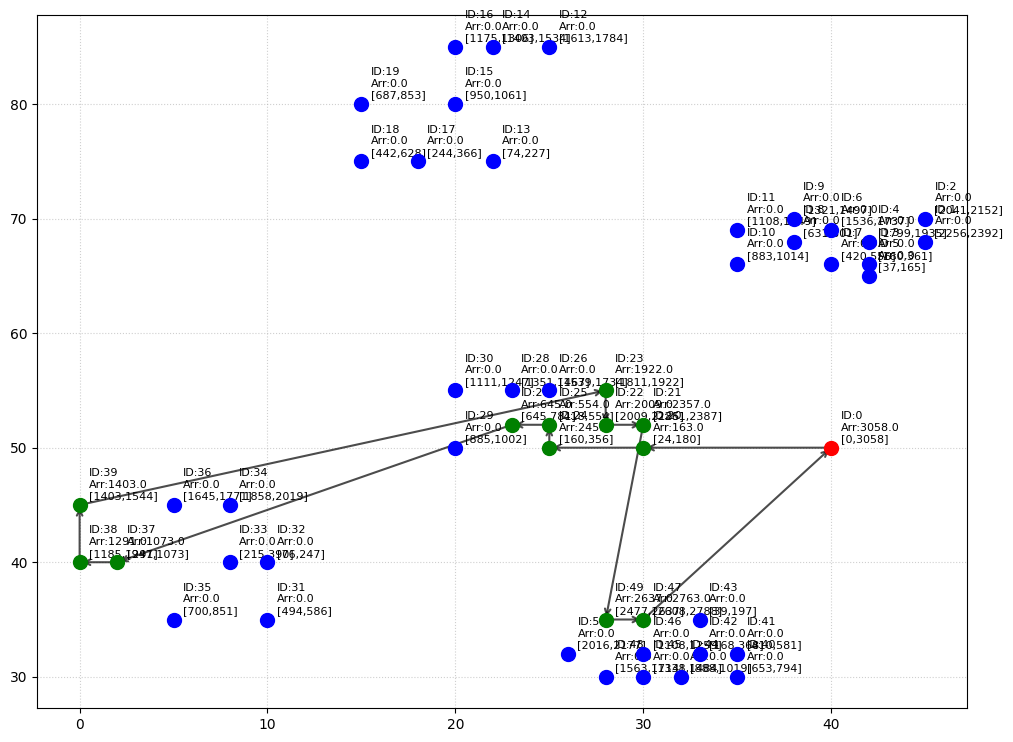

In [4]:
import matplotlib.pyplot as plt

def plot_2d_tour_from_results(graph, results, drone, k):

 
    nodes_to_include = list(results['arrival_times'].keys())
    if drone.base not in nodes_to_include:
        nodes_to_include.append(drone.base)
    
    sub_graph = graph.subgraph(nodes_to_include)
    # 1. Extract data from the results dictionary
    seq = results['sequence']
    arrivals = results['arrival_times']
    pos = {i: graph.nodes[i]['position'] for i in sub_graph.nodes}
    
    plt.figure(figsize=(12, 9))
    
    # 2. Draw Nodes and Time Info
    for i in sub_graph.nodes:
        x, y = pos[i]
        e_i, l_i = sub_graph.nodes[i]['time_window']
        arr_time = int(arrivals[i])
        
        # Color: Depot is Red, Visited is Green, Unvisited is Blue
        if i == drone.base:
            color = 'red'
        elif i in seq:
            color = 'green'
        else:
            color = 'blue'
            
        plt.scatter(x, y, c=color, s=100, zorder=5)
        
        # Label with Time Windows and Arrival
        # If node wasn't visited, arrival might be 0 or irrelevant
        label = f"ID:{i}\nArr:{arr_time:.1f}\n[{int(e_i)},{int(l_i)}]"
        plt.text(x + 0.5, y + 0.5, label, fontsize=8)

    # 3. Draw the Tour Path (Arrows)
    for k in range(len(seq)-1):
        u, v = seq[k], seq[k+1]
        plt.annotate("", xy=pos[v], xytext=pos[u],
                     arrowprops=dict(arrowstyle="->", color="black", lw=1.5, alpha=0.7))


    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

plot_2d_tour_from_results(graph, results, drone, k=10)

How to verify visually:Chronology: Follow the green arrows. The "Arr" (Arrival) value must increase as you move along the path (except when returning to the depot, where $a_0$ is usually the end of the mission).Constraint Satisfaction: Check every node: the "Arr" value must be between the two numbers in the brackets [e_i, l_i].Waiting Time: If you see a node where Arr equals the first number in the bracket (e.g., Arr: 50.0 and Win: [50, 150]), it means the drone arrived early and waited for the window to open.Efficiency: If the drone visits a node very close to the end of the window (e.g., Arr: 149.5 and Win: [50, 150]), the solver is "squeezing" that node in to maximize information.


    

The Bottleneck: If the utilization is low (e.g., 60%), but the solver has finished (0% gap), it confirms that your Time Windows are so tight that the drone simply cannot find more nodes to visit within the allowed schedule, even though it has plenty of fuel.

The "n/2" Validation: Since you calibrated for 25 nodes, if the MISOCP finds a tour with 22-25 nodes and 98% energy utilization, your calibration is perfect. It means the Solomon environment and your TB2 drone model are perfectly "in sync."

Heuristic Room: If the MISOCP uses 90% of the energy but your ILS only uses 40%, you know the local search needs better "Node Addition" operators to exploit the remaining battery.